In [15]:
from transformers import CLIPProcessor, CLIPModel
import pandas as pd
from PIL import Image
import os
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout, BatchNormalization

import numpy as np
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt


In [2]:
file_path = "C:\\Users\\alan\\Medical Image Project\\combine_data\\BrEaST-Lesions-USG-clinical-data-Dec-15-2023.xlsx"
text_data = pd.read_excel(file_path)

In [3]:

# filter out normal rows
filtered_text_data = text_data[(text_data['Classification'] == 'benign') | (text_data['Classification'] == 'malignant')]

# combine the relevant columns into a single text field per case
text_columns = [col for col in filtered_text_data.columns if col not in ['Image_filename', 'Classification', "Mask_tumor_filename","Mask_other_filename", "Pixel_size", "Verification","BIRADS"]]
filtered_text_data['combined_text'] = filtered_text_data[text_columns].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)



C:\Users\alan\AppData\Local\Temp\ipykernel_23492\3397113210.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_text_data['combined_text'] = filtered_text_data[text_columns].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)


In [4]:
model_name = "openai/clip-vit-base-patch32"
processor = CLIPProcessor.from_pretrained(model_name)
model = CLIPModel.from_pretrained(model_name)

text_inputs = processor(text=filtered_text_data["combined_text"].tolist(), padding=True, truncation=True, return_tensors="pt")


In [5]:
text_embeddings = model.get_text_features(**text_inputs)

In [6]:
# image feature extraction
def get_image_embedding(image_path, processor, model):
    # Load and process the image
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt")
    
    # Generate embedding
    with torch.no_grad():  # Ensure no gradients are calculated
        image_embedding = model.get_image_features(**inputs)
    
    return image_embedding


In [7]:
# Initialize an empty list to hold image embeddings
image_embeddings = []

# Base path for images
base_path = "C:\\Users\\alan\\Medical Image Project\\combine_data"

# Loop through each row in the DataFrame
for filename in filtered_text_data['Image_filename']:
    image_path = os.path.join(base_path, filename)
    embedding = get_image_embedding(image_path, processor, model)
    image_embeddings.append(embedding)

# Convert the list of embeddings into a tensor (or any format you prefer)
image_embeddings_tensor = torch.stack(image_embeddings)


In [8]:
# convert both embedding into same demision
image_embeddings_tensor = image_embeddings_tensor.squeeze(-1)  # Squeeze the last dimension if it's extraneous

image_embeddings_tensor = image_embeddings_tensor.view(image_embeddings_tensor.shape[0], -1)  # Flatten to [number_of_samples, image_feature_size * some_other_dimension]

# Now try concatenating again
combined_embeddings = torch.cat((text_embeddings, image_embeddings_tensor), dim=1)
print(text_embeddings.shape)
print(image_embeddings_tensor.shape)

torch.Size([252, 512])
torch.Size([252, 512])


In [9]:

print(combined_embeddings.shape)

torch.Size([252, 1024])


In [10]:
# add label
labels = filtered_text_data['Classification'].values
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)  # Converts labels to numerical format


In [25]:
# split the data

# Convert it to a NumPy array
X = combined_embeddings.detach().numpy()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, encoded_labels, test_size=0.2, random_state=42)

model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.2),                 # Dropout layer for regularization
    Dense(64, activation='relu'),
    BatchNormalization(),         # BatchNormalization layer for normalization
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with validation data
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.4, verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {test_loss}\nTest Accuracy: {test_accuracy}")

Epoch 1/10
4/4 [==============================] - 1s 53ms/step - loss: 0.9098 - accuracy: 0.4333 - val_loss: 0.7292 - val_accuracy: 0.4444
Epoch 2/10
4/4 [==============================] - 0s 11ms/step - loss: 0.6903 - accuracy: 0.6167 - val_loss: 0.6599 - val_accuracy: 0.5309
Epoch 3/10
4/4 [==============================] - 0s 12ms/step - loss: 0.4917 - accuracy: 0.7833 - val_loss: 0.5521 - val_accuracy: 0.7284
Epoch 4/10
4/4 [==============================] - 0s 12ms/step - loss: 0.4202 - accuracy: 0.7917 - val_loss: 0.4449 - val_accuracy: 0.8395
Epoch 5/10
4/4 [==============================] - 0s 12ms/step - loss: 0.3586 - accuracy: 0.8167 - val_loss: 0.3598 - val_accuracy: 0.9259
Epoch 6/10
4/4 [==============================] - 0s 12ms/step - loss: 0.2703 - accuracy: 0.9167 - val_loss: 0.3040 - val_accuracy: 0.9383
Epoch 7/10
4/4 [==============================] - 0s 12ms/step - loss: 0.1957 - accuracy: 0.9583 - val_loss: 0.2616 - val_accuracy: 0.9630
Epoch 8/10
4/4 [===========

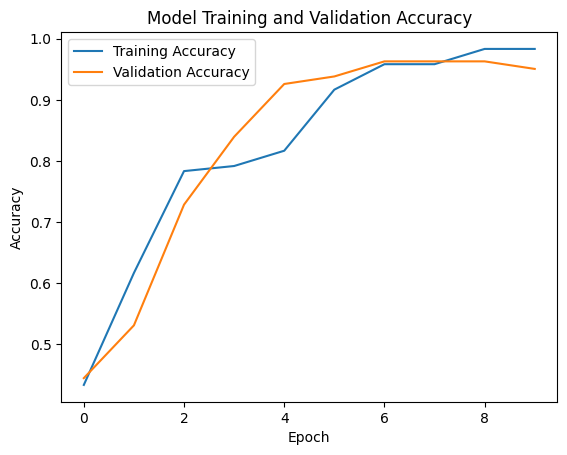

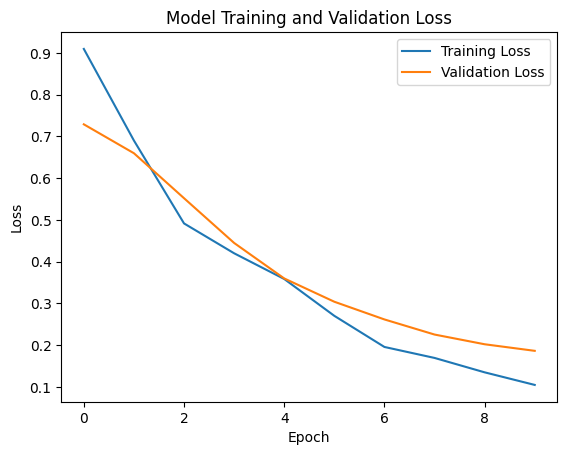

In [26]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()